In [1]:
%matplotlib inline

In [2]:
import argparse
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance

import torch
import cpc.feature_loader as fl
import cpc.train as tr
from cpc.dataset import AudioBatchData, findAllSeqs, filterSeqs, parseSeqLabels

In [3]:
sys.path.append(os.path.dirname(tr.__file__))

In [4]:
onEncodings = True

# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk-1neg/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-ground-truth-segmentation/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline2/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10-cosine/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-ground-truth-segmentation-cosine/checkpoint_30.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk-1neg-timit-cosine-norelu/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/cpc-kreuk-1neg-timit-norelu/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10-cosine-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-hierarchical-smartpooling10-cosine-norelu-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-timit/checkpoint_49.pt'
# CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/hacpc-gt-cosine-norelu-encodeseg-long-buckeye/checkpoint_49.pt'
CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/hacpc-gt-cosine-encodeseg-long-buckeye/checkpoint_49.pt'

In [5]:
cdata = fl.getCheckpointData(os.path.dirname(CP))
_, _, args = cdata
model, args.hiddenGar, args.hiddenEncoder = fl.loadModel([CP])
assert args.speakerEmbedding == 0

try:
    criterion = tr.loadCriterion(CP, model.gEncoder.DOWNSAMPLING, len(speakers), None)
except:
    criterion = None
    print("Failed to load criterion :(((())))")

Loading checkpoint /pio/scratch/1/i323106/wav2vec/runs/cpc/hacpc-gt-cosine-encodeseg-long-buckeye/checkpoint_49.pt
LocArgs: Namespace(CPCCTC=True, CPCCTCLearnBlank=False, CPCCTCLossTemp=1.0, CPCCTCMasq='', CPCCTCNoNegsMatchWin=False, CPCCTCNormalizeEncs=False, CPCCTCNormalizePreds=False, CPCCTCNumLevels=2, CPCCTCNumMatched=12, CPCCTCSelfLoop=False, CPCCTCSkipBeg=0, CPCCTCSkipEnd=0, CTC=False, CTCphones=False, abspos=False, arMode='LSTM', batchSizeGPU=16, beta1=0.9, beta2=0.999, captureCPCCTCalign=False, captureCPCCTClogScores=False, captureConvRepr=False, captureCtxRepr=False, captureDSfreq=None, captureDStotNr=None, captureEachEpochs=10, captureEverything=False, capturePhoneAlign=False, capturePred=False, captureSetStats=None, captureSpeakerAlign=False, cpc_mode=None, debug=False, dropout=True, encodeSegments=True, encoder_type='cpc', epsilon=1e-08, file_extension=['.wav'], gru_level=-1, headWeights=[1.0, 1.0], hiddenEncoder=256, hiddenGar=256, ignore_cache=True, learningRate=0.0002, 

In [6]:
phoneNames = [
    'SIL','SPN','S','UW','T','N','K','Y','Z','AO','AY','SH','W','NG','EY',
    'B','CH','OY','JH','D','ZH','G','UH','F','V','ER','AA','IH',
    'M','DH','L','AH','P','OW','AW','HH','AE','R','TH','IY','EH'
]
codes2phones = {i: j for (i, j) in enumerate(phoneNames)}

In [7]:
args.pathDB = ['/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100']
args.pathTrain = ['/pio/gluster/data/ls-train-clean-100/train_split.txt']
args.pathVal = ['/pio/gluster/data/ls-train-clean-100/test_split.txt']
args.pathPhone = '/pio/gluster/data/ls-train-clean-100/converted_aligned_phones.txt'
args.size_window = 20480
args.file_extension = ['.flac']
args.ignore_cache = True

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))


837it [00:04, 209.25it/s]


Ran in an error while saving /pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt: [Errno 13] Permission denied: '/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt'


10it [00:00, 167103.75it/s]

Checking length...
Done, elapsed: 0.027 seconds
Scanned 10 sequences in 0.03 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.089 secs


In [8]:
model.cpu()
if criterion is not None:
    criterion.cpu()
val_loader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
data_iter = iter(val_loader)
batch_data, label = next(data_iter)
c_feature, encoded_data, _ = model(batch_data, None)

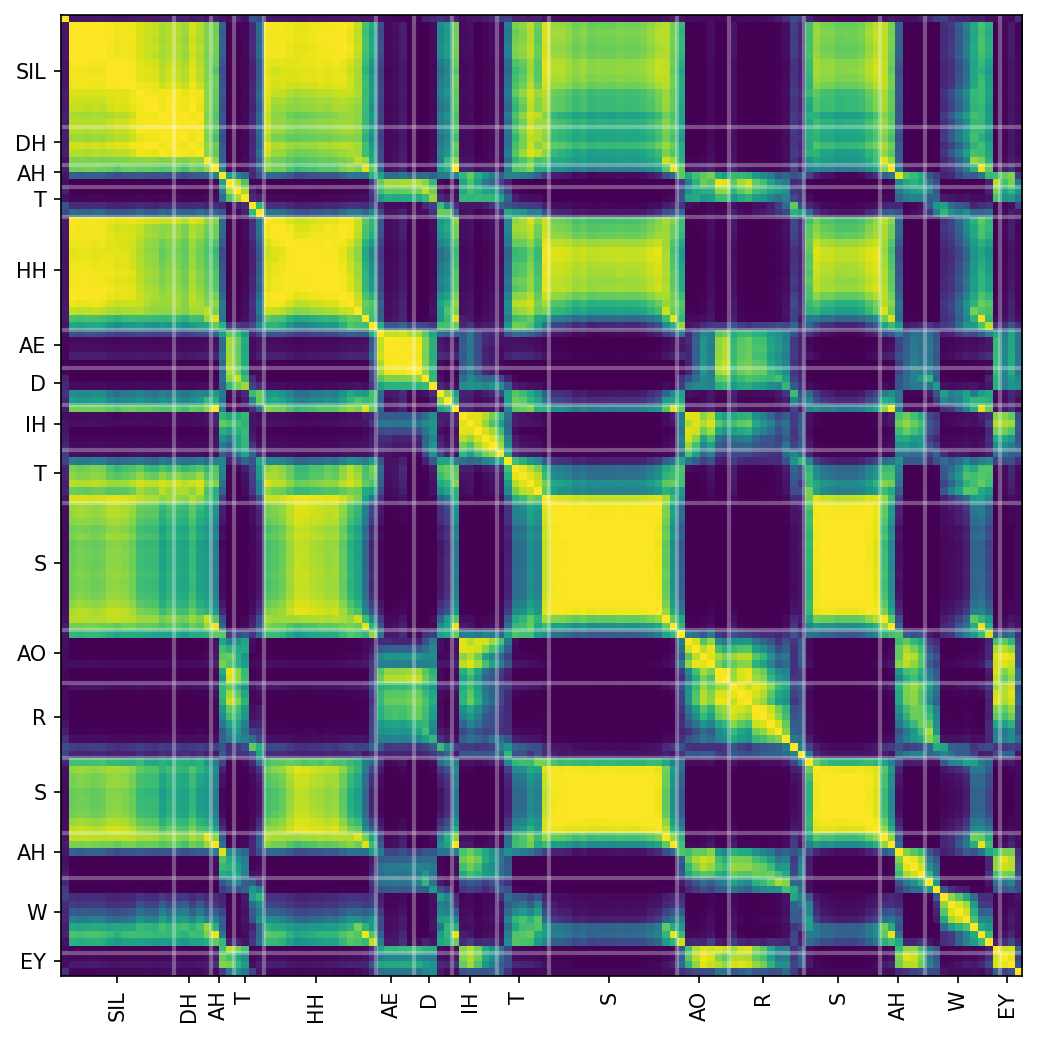

In [9]:
# the paper has these figures
if onEncodings:
    features = encoded_data
else:
    features = c_feature[0]

trunc = 64  # or None for full plot
trunc = None

plt.figure(figsize=(7, 7), dpi=150)
phones = label['phone'][0,:trunc].numpy()

enc = features[0, :trunc, :].detach().numpy()
enc /= np.sqrt((enc**2).sum(1, keepdims=True))
sims = (enc @ enc.T) / enc.shape[-1]

plt.imshow(sims)
for boundary in np.where(np.diff(phones))[0] + 0.5:
    plt.axhline(boundary, color='w', linewidth=2, alpha=0.3)
    plt.axvline(boundary, color='w', linewidth=2, alpha=0.3)
#plt.colorbar()
plt.tight_layout()
# plt.axis('off')
bars = np.concatenate([[0], np.where(np.diff(phones))[0], [sims.shape[1]-1]])
phone_locs = (bars[:-1] + bars[1:]) / 2
_ = plt.xticks(phone_locs, [codes2phones[p] for p in phones[bars[1:]]], rotation=90)
_ = plt.yticks(phone_locs, [codes2phones[p] for p in phones[bars[1:]]])
if onEncodings:
    plt.savefig(CP.split('/')[-2])
else:
    plt.savefig(CP.split('/')[-2] + '_c')

In [10]:
# waveform = batch_data.cpu().numpy().reshape(-1)
# Z = features.detach().cpu().numpy().reshape(features.shape[1], features.shape[2]).T
# x = np.arange(0, 128)
# y = np.arange(0, 256)
# X, Y = np.meshgrid(x, y)
# # plt.subplot(211)
# # plt.plot(waveform)
# plt.figure(figsize=(7, 7), dpi=150)
# plt.subplot(211)
# plt.specgram(waveform, Fs=16000)
# plt.subplot(212)
# plt.contourf(X, Y, Z, 10)
# plt.tight_layout()
# plt.savefig(CP.split('/')[-2] + '_spectrogram')

In [11]:
phones2codes = {  # phonemes which should be the same for TIMIT
    'a': 0, 'aa': 1, 'aan': 2, 'ae': 3, 'aen': 4, 'ah': 0, 'ahn': 5, 'an': 5, 
    'ao': 6, 'aon': 7, 'aw': 8, 'awn': 9, 'ay': 10, 'ayn': 11, 'b': 12, 'ch': 13, 
    'd': 14, 'dh': 15, 'dx': 16, 'eh': 17, 'ehn': 18, 'el': 19, 'em': 20, 'en': 21, 
    'eng': 22, 'er': 23, 'ern': 24, 'ey': 25, 'eyn': 26, 'f': 27, 'g': 28, 'h': 29, 
    'hh': 29, 'hhn': 30, 'i': 31, 'id': 31, 'ih': 31, 'ihn': 32, 'iy': 33, 'iyih': 32, 
    'iyn': 32, 'jh': 34, 'k': 35, 'l': 36, 'm': 37, 'n': 38, 'ng': 39, 'nx': 40, 
    'ow': 41, 'own': 42, 'oy': 43, 'oyn': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 
    'sh': 49, 't': 50, 'th': 51, 'tq': 46, 'uh': 52, 'uhn': 53, 'uw': 54, 'uwix': 54, 
    'uwn': 55, 'v': 56, 'w': 57, 'y': 58, 'z': 59, 'zh': 60, '-': 61, '#': 62,
    'x': 63, 'no': 64
}

codes2phones = {v: k for k, v in phones2codes.items()}

In [12]:
args.pathDB = ['/pio/scratch/1/i323106/data/BUCKEYE/test/']
args.pathPhone = '/pio/scratch/1/i323106/data/BUCKEYE/converted_aligned_phones.txt'
args.size_window = 20480
args.file_extension = ['.wav']

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = seqNames[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))

5it [00:00, 557.50it/s]


Saved cache file at /pio/scratch/1/i323106/data/BUCKEYE/test/_seqs_cache.txt


10it [00:00, 164482.51it/s]

Checking length...
Done, elapsed: 0.003 seconds
Scanned 10 sequences in 0.00 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.313 secs


In [13]:
model.cpu()
if criterion is not None:
    criterion.cpu()
valLoader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
dataIter = iter(valLoader)
batchData, label = next(dataIter)
with torch.no_grad():
    cFeature, encodedData, _ = model(batchData, None)

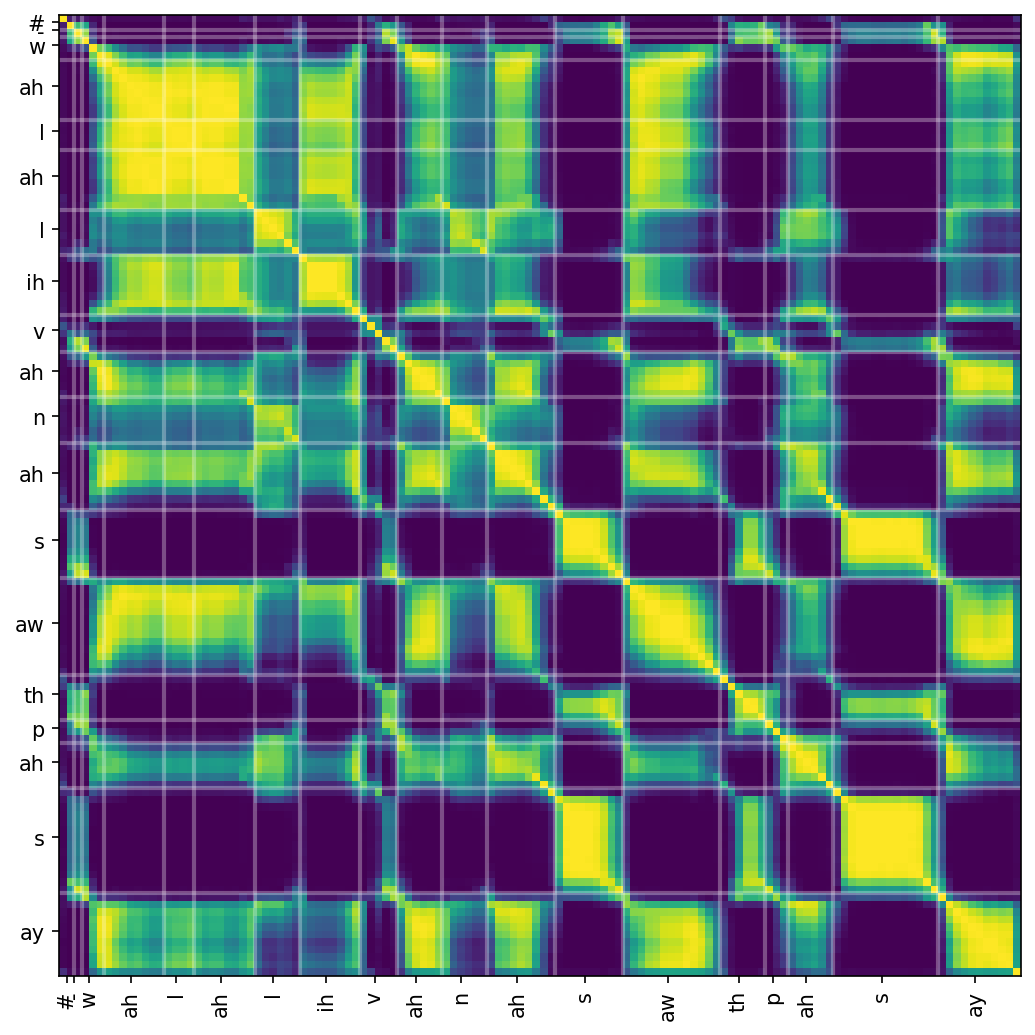

In [14]:
# the paper has these figures
if onEncodings:
    features = encodedData
else:
    features = cFeature[0]

trunc = 64  # or None for full plot
trunc = None

plt.figure(figsize=(7, 7), dpi=150)
phones = label['phone'][0,:trunc].numpy()

enc = features[0, :trunc, :].detach().numpy()
enc /= np.sqrt((enc**2).sum(1, keepdims=True))
sims = (enc @ enc.T) / enc.shape[-1]

plt.imshow(sims)
for boundary in np.where(np.diff(phones))[0] + 0.5:
    plt.axhline(boundary, color='w', linewidth=2, alpha=0.3)
    plt.axvline(boundary, color='w', linewidth=2, alpha=0.3)
#plt.colorbar()
plt.tight_layout()
# plt.axis('off')
bars = np.concatenate([[0], np.where(np.diff(phones))[0], [sims.shape[1]-1]])
phone_locs = (bars[:-1] + bars[1:]) / 2
_ = plt.xticks(phone_locs, [codes2phones[p] for p in phones[bars[1:]]], rotation=90)
_ = plt.yticks(phone_locs, [codes2phones[p] for p in phones[bars[1:]]])
if onEncodings:
    plt.savefig(CP.split('/')[-2]+ '_buckeye')
else:
    plt.savefig(CP.split('/')[-2] + '_buckeye_c')